In [1]:
import xarray as xr
import geopandas as gpd
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
from shapely.geometry import Polygon, MultiPolygon, MultiPoint
import matplotlib.pyplot as plt

import geokit as gk

import FINE as fn
import FINE.spagat.dataset as spd
import FINE.spagat.representation as spr 
import FINE.IOManagement.xarray_io as xrio 

# FUNCTIONS 

In [2]:
def read_shape_data(sds, SHP_PATH, index_col='e-id', geometry_column='geometry', srs=4326):
    """Read shape data from shapefiles."""

    #USING GEOKIT
    gkdf = gk.vector.extractFeatures(SHP_PATH, srs=srs)
    region_ids = gkdf[index_col].values

    sds.gkdf = gkdf
    sds.add_region_data(region_ids)
    sds.add_objects(description ='gk_geometries',  
                    dimension_list =['region_ids'], 
                    object_list = gkdf.geom)


    # USING GEOPANDAS 
#     gdf = gpd.read_file(SHP_PATH)
# region_ids = gdf[index_col].values
#     sds.gdf = gdf
#     sds.add_region_data(region_ids)
#     sds.add_objects(description ='gpd_geometries',  
#                     dimension_list =['region_ids'], 
#                     object_list = gdf.geometry)

    return sds

In [3]:
def rasterize_xarray(sds, 
                     shape, 
                     x_coord='x', 
                     y_coord='y', 
                     srs=gk.srs.EPSG3035):
    '''Takes a gridded xarray dataset and a geokit shape to raster the dataset
    based on the shape'''

    x_min = float(sds[x_coord].min().values)
    x_max = float(sds[x_coord].max().values)
    y_min = float(sds[y_coord].min().values)
    y_max = float(sds[y_coord].max().values)

    dy = sds[y_coord][1].values - sds[y_coord][0].values
    dx = sds[x_coord][1].values - sds[x_coord][0].values

    # TODO: discuss with Sev whether the following can be generalized
    # without using dx and dy, such that generalization for cosmo becomes easier
    gk_ds = gk.vector.rasterize(source=shape, 
                                pixelWidth=dx, 
                                pixelHeight=dy,
                                srs=srs, 
                                bounds=(x_min, y_min, x_max, y_max))

    # TODO: understand, why y axis is inversed when ReadAsArray
    return np.flip(gk_ds.ReadAsArray(), 0)
    # return gk_ds.ReadAsArray()


In [4]:
def add_rasters(sds, 
                region_description='region_ids',
                x_coord='x', 
                y_coord='y',
                srs=gk.srs.EPSG3035):

        sds.xr_dataset['rasters'] = ([region_description, 'y', 'x'],
                                      [rasterize_xarray(sds.xr_dataset, 
                                                            geometry.item(0),
                                                            x_coord=x_coord, 
                                                            y_coord=y_coord,
                                                            srs=srs)
                                       for geometry in sds.xr_dataset['gk_geometries']])


<xarray.DataArray (x: 5, y: 3, time: 10)>
array([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])
Coordinates:
  * x        (x) int32 1 2 3 5 6
  * y        (y) int32 1 2 3
  * time     (time) int32 0 1 2 3 4 5 6 7 8 9

array([[[  0.08848433,   2.32299086,   1.70735537,   1.05401263,
          -0.29661333,   4.12026211,  -1.63558259,   7.53315727,
           8.22470224,  -3.75118756],
        [  0.46546494,   3.12315514,   2.02708529,   1.32599553,
          -1.46038679,   3.22035416,  -1.88257787,   7.47271885,
           8.60079476,  -2.69072279],
        [ -0.73000011,   6.25456272,   1.54561534,   0.45958936,
          -2.77969937,   3.69537262,  -2.86215362,   7.62271974,
           8.37778865,  -1.94426713]],

       [[ -5.57011344,   7.39473874,  -1.14499673,   2.17113537,
          -8.67695202,   2.19769985,   2.85599382,   3.26088661,
           9.2513871 ,   2.53700519],
        [  9.78064182,   6.95981032,  -0.41404636,   6.31715669,
          -7.62401146,   4.58429092,  -7.00602216,   9.2953677 ,
           2.32011713,  -3.05452026],
        [  6.97390145,  -0.65692743,   1.76323286,   7.82712267,
          -9.45007599,  -8.83626367,  -9.90718458,   6.70856225,
           4.39798518,   8.3

array([[[  4.20430241,   1.04068065,   0.45359286,   8.56387816,
          -7.85018827,  -8.1284311 ,  -8.45623137,   5.41757109,
           5.96547666,   6.71543287],
        [  1.0220286 ,   4.11660348,   3.58804674,   2.36702243,
          -1.37195659,   3.29604478,  -2.13604152,   5.85466355,
           8.92534306,  -2.17482065],
        [  5.90101798,   0.88037029,   0.72656913,   8.1491916 ,
          -9.25173928,  -8.61696717, -10.40877833,   4.92611431,
           5.74056116,   6.99846203]],

       [[  2.20656076,   5.50616718,   1.6679407 ,   0.59536091,
          -2.57545698,   1.49786432,  -2.95452597,   9.78623541,
           8.76360303,  -2.76924393],
        [  4.5817054 ,   1.35538875,  -0.25300663,   8.29919249,
          -9.4747454 ,  -7.87051151, -10.10643719,   5.47176473,
           5.53495279,   7.82857484],
        [  2.47034915,   4.09862906,   2.36833522,   0.04356792,
          -4.07989383,   3.57150086,  -0.38381958,   7.093295  ,
          11.54300983,  -3.7

In [14]:
test_capacity_dataarray

<xarray.DataArray (x: 5, y: 3)>
array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])
Coordinates:
  * x        (x) int32 1 2 3 5 6
  * y        (y) int32 1 2 3

<xarray.Dataset>
Dimensions:   (time: 10, x: 5, y: 3)
Coordinates:
  * x         (x) int32 1 2 3 5 6
  * y         (y) int32 1 2 3
  * time      (time) int32 0 1 2 3 4 5 6 7 8 9
Data variables:
    capacity  (x, y) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0 1.0
    capfac    (x, y, time) float64 0.08848 2.323 1.707 ... 7.093 11.54 -3.786

In [16]:
# polygon1 = Polygon([(0,0), (2,0), (2,2), (0,2)])
# polygon2 = Polygon([(3,0), (3,2), (4,2), (4,0)])

# test_geometries = [MultiPolygon([polygon1]),
#                    MultiPolygon([polygon2])] 

# df = pd.DataFrame({'region_ids': ['reg_01', 'reg_02']})

# gdf = gpd.GeoDataFrame(df, geometry=test_geometries, crs=f'epsg:{3035}') 

In [17]:
geom_reg_1 = [[0,0], [4,0], [4,4], [0,4]]
geom_reg_2 = [[4,0], [7,0],[7,4], [4,4]]

mp = MultiPoint(geom_reg_1)
conv_hull = mp.convex_hull
poly_reg_1 = Polygon(conv_hull)
# poly_reg_1 = gpd.GeoSeries(poly_reg_1)

mp = MultiPoint(geom_reg_2)
conv_hull = mp.convex_hull
poly_reg_2 = Polygon(conv_hull)

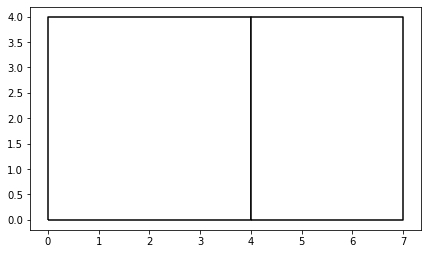

In [21]:
# sds = read_shape_data(sds, TEST_SHP_PATH, index_col='region_ids', srs=3035)

In [22]:
sds.xr_dataset

<xarray.Dataset>
Dimensions:        (region_ids: 2, space: 2, space_2: 2, time: 10, x: 5, y: 3)
Coordinates:
  * x              (x) int32 1 2 3 5 6
  * y              (y) int32 1 2 3
  * time           (time) int32 0 1 2 3 4 5 6 7 8 9
  * space          (space) object 'reg_01' 'reg_02'
  * space_2        (space_2) object 'reg_01' 'reg_02'
Dimensions without coordinates: region_ids
Data variables:
    capacity       (x, y) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    capfac         (x, y, time) float64 0.08848 2.323 1.707 ... 11.54 -3.786
    gk_geometries  (region_ids) object POLYGON ((0 0,0 4,4 4,4 0,0 0)) POLYGO...

In [23]:
sds.gkdf

,geom,region_ids
0,"POLYGON ((0 0,0 4,4 4,4 0,0 0))",reg_01
1,"POLYGON ((4 0,4 4,7 4,7 0,4 0))",reg_02


In [24]:
add_rasters(sds, srs=3035)

ValueError: conflicting sizes for dimension 'y': length 2 on 'rasters' and length 3 on 'y'

# REAL RUN-----------------------------------------------

In [ ]:
# Initialize spagat dataset 
sds = spd.SpagatDataset()

In [ ]:
# Read Input Data 
GRIDDED_WIND_PATH = 'C:/Users/s.patil/Documents/code/fine/experiments/REPRESENTATION/InputData/onshore_solar_openfieldfixed_2015.nc4'
sds.xr_dataset = xr.open_dataset(GRIDDED_WIND_PATH)  #, chunks={'time': 8760, 'x': 20, 'y': 21}

sds.xr_dataset.coords

sds.xr_dataset.data_vars

In [ ]:
# STEP 3. Read Shapefile
SHP_PATH = 'C:/Users/s.patil/Documents/code/fine/experiments/REPRESENTATION/InputData/Shapefiles/e-highway_sev-full.shp' #TODO: get without offshore (96 regions must be present not 169)
sds = read_shape_data(sds, SHP_PATH, srs=4326)
sds.xr_dataset.coords  #TODO: Check why space is taken and not "region_ids"
sds.gkdf

In [ ]:
add_rasters(sds, srs=3035)

# ---------------------------------------------------------------------

In [25]:
from rasterio import features
from affine import Affine

In [35]:
sds = spd.SpagatDataset()

In [36]:
sds.xr_dataset

<xarray.Dataset>
Dimensions:  ()
Data variables:
    *empty*

In [37]:
sds.xr_dataset = test_Dataset

In [38]:
sds.xr_dataset 

<xarray.Dataset>
Dimensions:   (time: 10, x: 5, y: 3)
Coordinates:
  * x         (x) int32 1 2 3 5 6
  * y         (y) int32 1 2 3
  * time      (time) int32 0 1 2 3 4 5 6 7 8 9
Data variables:
    capacity  (x, y) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0 1.0
    capfac    (x, y, time) float64 0.08848 2.323 1.707 ... 7.093 11.54 -3.786

<xarray.Dataset>
Dimensions:     (region_ids: 2, time: 10, x: 5, y: 3)
Coordinates:
  * region_ids  (region_ids) object 'reg_01' 'reg_02'
  * x           (x) int32 1 2 3 5 6
  * y           (y) int32 1 2 3
  * time        (time) int32 0 1 2 3 4 5 6 7 8 9
Data variables:
    capacity    (region_ids, x, y) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    capfac      (region_ids, x, y, time) float64 0.08848 2.323 ... 11.54 -3.786
    rasters     (region_ids, y, x) float64 1.0 1.0 1.0 nan ... nan nan 1.0 1.0

In [45]:
subset

<xarray.Dataset>
Dimensions:     (region_ids: 1, time: 10, x: 5, y: 3)
Coordinates:
  * region_ids  (region_ids) object 'reg_02'
  * x           (x) int32 1 2 3 5 6
  * y           (y) int32 1 2 3
  * time        (time) int32 0 1 2 3 4 5 6 7 8 9
Data variables:
    capacity    (region_ids, x, y) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    capfac      (region_ids, x, y, time) float64 0.08848 2.323 ... 11.54 -3.786
    rasters     (region_ids, y, x) float64 nan nan nan 1.0 ... nan nan 1.0 1.0

In [49]:
subset.rasters.sel(region_ids="reg_02")

<xarray.DataArray 'rasters' (y: 3, x: 5)>
array([[nan, nan, nan,  1.,  1.],
       [nan, nan, nan,  1.,  1.],
       [nan, nan, nan,  1.,  1.]])
Coordinates:
    region_ids  <U6 'reg_02'
  * x           (x) int32 1 2 3 5 6
  * y           (y) int32 1 2 3

<xarray.DataArray 'capfac' (region_ids: 1, x: 5, y: 3, time: 10)>
array([[[[         nan,          nan,          nan,          nan,
                   nan,          nan,          nan,          nan,
                   nan,          nan],
         [         nan,          nan,          nan,          nan,
                   nan,          nan,          nan,          nan,
                   nan,          nan],
         [         nan,          nan,          nan,          nan,
                   nan,          nan,          nan,          nan,
                   nan,          nan]],

        [[         nan,          nan,          nan,          nan,
                   nan,          nan,          nan,          nan,
                   nan,          nan],
         [         nan,          nan,          nan,          nan,
                   nan,          nan,          nan,          nan,
                   nan,          nan],
         [         nan,          nan,          nan,          nan,
                   nan,          nan,          nan,          nan,
                   nan,          nan]],

...

        [[  4.20430241,   1.04068065,   0.45359286,   8.56387816,
           -7.85018827,  -8.1284311 ,  -8.45623137,   5.41757109,
            5.96547666,   6.71543287],
         [  1.0220286 ,   4.11660348,   3.58804674,   2.36702243,
           -1.37195659,   3.29604478,  -2.13604152,   5.85466355,
            8.92534306,  -2.17482065],
         [  5.90101798,   0.88037029,   0.72656913,   8.1491916 ,
           -9.25173928,  -8.61696717, -10.40877833,   4.92611431,
            5.74056116,   6.99846203]],

        [[  2.20656076,   5.50616718,   1.6679407 ,   0.59536091,
           -2.57545698,   1.49786432,  -2.95452597,   9.78623541,
            8.76360303,  -2.76924393],
         [  4.5817054 ,   1.35538875,  -0.25300663,   8.29919249,
           -9.4747454 ,  -7.87051151, -10.10643719,   5.47176473,
            5.53495279,   7.82857484],
         [  2.47034915,   4.09862906,   2.36833522,   0.04356792,
           -4.07989383,   3.57150086,  -0.38381958,   7.093295  ,
           11.54300983,  -3.7855353 ]]]])
Coordinates:
  * region_ids  (region_ids) object 'reg_02'
  * x           (x) int32 1 2 3 5 6
  * y           (y) int32 1 2 3
  * time        (time) int32 0 1 2 3 4 5 6 7 8 9

In [ ]:
reg_2_sds = sds.xr_dataset.where(sds.xr_dataset.rasters[1:])

In [ ]:
reg_2_sds = sds.xr_dataset.where(sds.xr_dataset.rasters[1:])

In [ ]:
reg_2_sds.capacity.where(sds.xr_dataset.rasters.sel(region_ids="reg_02"))

In [ ]:
reg_2_sds.capacity.where(sds.xr_dataset.rasters[1:])